In [11]:
import numpy as np
import matplotlib.pyplot as plt
import batman
from scipy.stats import norm

making an XX plot for the broadband data

In [70]:
## Loading in the HST/WFC3 G141 broadband light curve
loadBroadBand = False
if loadBroadBand:
    def transit(theta, initmodel, telescope='HST'):
        # Transit Light curve model
        # Inputs:
        # theta = array of lightcurve parameters
        # initmodel = pre-initialized BATMAN model environment, which increases efficiency
        # telescope = toggle between using TESS and HST radius

        # Unpack input parameters
        tc = theta[0]       # time of conjunction [days]
        log10P = theta[1]   # log10( Period [days] )
        log10a = theta[2]   # log10( a / Rstar )
        cosi = theta[3]     # cosine(inclination [rad])
        if telescope == 'HST':
            rprstar = theta[4]
        elif telescope == 'TESS':
            rprstar = theta[11]
        par1 = theta[12]
        par2 = theta[13]

        # Transform input parameters to forms used by BATMAN
        P = 10.**(log10P)  # compute Period in [day]
        a = 10.**(log10a)  # compute a/Rstar
        inc = np.arccos(cosi)*(180./np.pi)  # Compute inclination in [deg]
        ecc = par1**2 + par2**2     # eccentricity
        omega = np.arctan2(par2, par1)  # argument of periapsis

        # Initialize batman parameters
        params = batman.TransitParams()
        params.t0 = tc             # transit midpoint [day]
        params.per = P    # log10 (period [day])
        params.rp = rprstar
        params.a = a      # log10 (semi major axis [Rstar])
        params.inc = inc  # cosine inclination [degrees]
        params.ecc = ecc
        params.w = omega
        params.limb_dark = 'quadratic'
        params.u = [0.16, 0.31]

        lightcurve = initmodel.light_curve(params)
        return lightcurve
    ##
    # Defining my systematic models
    def hook(theta, torbit):
        # Orbit-long charge trapping hook model for HST
        # Inputs:
        # theta = array of lightcurve parameters
        # torbit = time since start of corresponding orbit in units [day]

        amplitude2 = theta[5]
        amplitude3 = theta[6]
        tau2 = theta[7]
        tau3 = theta[8]

        hookcurve = np.zeros(len(torbit))
        hookcurve[:17] = 1. - amplitude2*np.exp(torbit[:17]/tau2)
        hookcurve[17:] = 1. - amplitude3*np.exp(torbit[17:]/tau3)
        return hookcurve

    def ramp(theta, tvisit):
        # Visit-long linear model for flux in time
        # Inputs:
        # theta = array of lightcurve parameters
        # tvisit = time since start of visit in units [day]    
        slope = theta[9]
        intercept = theta[10]

        y = intercept + (slope*tvisit)
        return y
    
    bbdata = np.load('/home/mmmurphy/data/hd219666b/reduced_data/Transit_Broad_Visit3_NoFirst.npz')
    times_bb = bbdata['time']
    rawfluxes_bb = bbdata['flux']
    rawerrors_bb = bbdata['error']
    scandirs = bbdata['scandir']

    # normalizing the flux and flux error values
    fluxes_bb, errors_bb = np.copy(rawfluxes_bb), np.copy(rawerrors_bb)
    sd1_idxs, sd0_idxs = np.where(scandirs == 1.)[0], np.where(scandirs == 0.)[0]
    normval1, normval0 = np.median(rawfluxes_bb[sd1_idxs]), np.median(rawfluxes_bb[sd0_idxs])
    fluxes_bb[sd1_idxs] /= normval1
    errors_bb[sd1_idxs] /= normval1
    fluxes_bb[sd0_idxs] /= normval0
    errors_bb[sd0_idxs] /= normval0
    
    # creating the relative time arrays
    t_visit_bb = times_bb - times_bb[0]  # time since start of visit [day]

    orbit_ends = np.array([17, 34, 51]) # indeces separing each orbit (note: orbit1 excluded)
    orbit2times = times_bb[:orbit_ends[0]]
    orbit3times = times_bb[orbit_ends[0] : orbit_ends[1]]
    orbit4times = times_bb[orbit_ends[1] : orbit_ends[2]]
    # From above, compute time since beginning of orbit for each
    tinorbit2 = orbit2times - orbit2times[0]
    tinorbit3 = orbit3times - orbit3times[0]
    tinorbit4 = orbit4times - orbit4times[0]
    t_orbit_bb = np.concatenate((tinorbit2, tinorbit3, tinorbit4))
    print('data loaded in')

    
    path = '/home/mmmurphy/data/hd219666b/mcmc_results/jointfit/'
    sfile = path+'samples_50ksteps.npy'
    ffile = path+'flatsamples_50ksteps.npy'
    tfile = path+'autocorrtimes_50ksteps.npy'
    samples = np.load(sfile)
    flatsamples = np.load(ffile)
    autocorrtimes = np.load(tfile)
    print('chains loaded in from file in ', path)
    
    param_fits = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
    param_uperrs = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - param_fits
    param_loerrs = param_fits - np.asarray([np.percentile(flatsamples[:,i], 16) for i in range(samples.shape[2])])
    param_errs = np.mean((param_uperrs, param_loerrs), axis=0)
    print('best fit parameters computed')
    
    # initializing the batman model
    InitParams = batman.TransitParams()
    InitParams.t0 = param_fits[0]      
    InitParams.per = 10.**param_fits[1]
    InitParams.a = 10.**param_fits[2]
    InitParams.inc = np.arccos(param_fits[3])*(180./np.pi)
    InitParams.rp = param_fits[4]
    InitParams.ecc = 0.
    InitParams.w = 90.
    InitParams.limb_dark = 'quadratic'
    InitParams.u = [0.16, 0.31]
    BATMAN_bbinitmodel = batman.TransitModel(InitParams, times_bb)
    print('BATMAN model created')
    
    # Generating models with best-fit parameters
    bf_bbtransit = transit(param_fits, BATMAN_bbinitmodel, 'HST')
    bf_bbhook = hook(param_fits, t_orbit_bb)
    bf_ramp = ramp(param_fits, t_visit_bb)
    bf_bbsys = bf_bbhook * bf_ramp
    bf_bbmodel = bf_bbtransit * bf_bbsys
    print('best fit models computed')

    detflux_bb, deterrs_bb = fluxes_bb / bf_bbsys, errors_bb / bf_bbsys
    residuals_bb = 1.e6*(fluxes_bb - bf_bbmodel)
    print('residuals computed')

In [71]:
if loadBroadBand:
    # looking at the un-binned residuals
    fig, ax = plt.subplots(figsize=(6,4))
    ax.axhline(0., c='black', alpha=0.25)
    ax.scatter(times_bb, residuals_bb, c='blue', s=3)
    mu_ub_bb, sd_ub_bb = norm.fit(residuals_bb)
    ax.text(0.1, 0.1, 'S.D. = %.1f ppm'%(sd_ub_bb), c='black', 
           fontsize=8, transform=ax.transAxes)
    ax.set(xlabel='Time', ylabel='Residual [ppm]', title='Unbinned Broadband Residuals')
    plt.show()

In [72]:
if loadBroadBand:
    max_every_N_to_bin = 25
    mean_resids = np.zeros(max_every_N_to_bin)
    sd_resids = np.zeros(max_every_N_to_bin)
    timesteps = np.zeros(max_every_N_to_bin)
    t_exp = times_bb[1] - times_bb[0]
    for bin_size in range(max_every_N_to_bin):
        #print('binning every %d points'%(bin_size + 1))
        this_binnings_residuals = []
        binn = 0
        while binn < len(residuals_bb):
            #print('bin number %d'%(binn))
            vals_to_combine = []
            for nextn in range(bin_size+1):
                if (binn + nextn) >= len(residuals_bb):
                    continue
                vals_to_combine.append(residuals_bb[binn+nextn])
            vals_to_combine = np.asarray(vals_to_combine)
            #print('values: ',vals_to_combine)
            median_value = np.median(vals_to_combine)
            this_binnings_residuals.append(median_value)
            binn += (bin_size + 1)

        this_binnings_residuals = np.asarray(this_binnings_residuals)
        mu, sd = norm.fit(this_binnings_residuals)
        mean_resids[bin_size] = mu
        sd_resids[bin_size] = sd

        timestep_size = t_exp * (bin_size + 1)
        timestep_size_min = timestep_size * 24. * 60.
        timesteps[bin_size] = timestep_size_min

    whitenoise_x = np.copy(timesteps)
    whitenoise_y = np.zeros(len(whitenoise_x))
    for i, val in enumerate(whitenoise_x):
        N = i + 1
        unbinned_sd = sd_resids[0]
        wn_sd = unbinned_sd / np.sqrt(N)
        whitenoise_y[i] = wn_sd

    orbit_length = tinorbit2[-1]
    orbit_length_min = orbit_length * 24. * 60.
    fig, ax = plt.subplots(figsize=(6,4))
    ax.axvline(orbit_length_min, c='gray', alpha=0.25, label='HST Orbit Length')
    ax.plot(whitenoise_x, whitenoise_y, c='black', ls='--', label='Whitenoise expectation')
    ax.plot(timesteps, sd_resids, c='blue', marker='o', ms=3, label='Observed, Broadband')
    ax.set(xlabel='Bin Size [minutes]', ylabel='Standard Deviation of Residuals [ppm]', xscale='log', yscale='log')
    ax.legend(loc='upper right', fontsize=8, frameon=True)
    plt.savefig('figures/whitenoise_comp_bb.png', dpi=400, bbox_inches='tight')
    plt.show()


data loaded in
wavelength bin  0  ----
chains loaded in
best fit params computed
batman model initialized
models computed
residuals computed


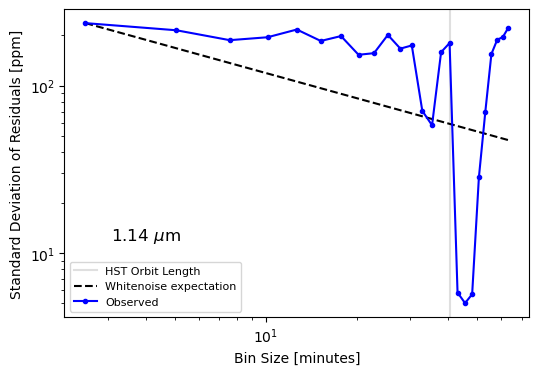

wavelength bin  1  ----
chains loaded in
best fit params computed
batman model initialized
models computed
residuals computed


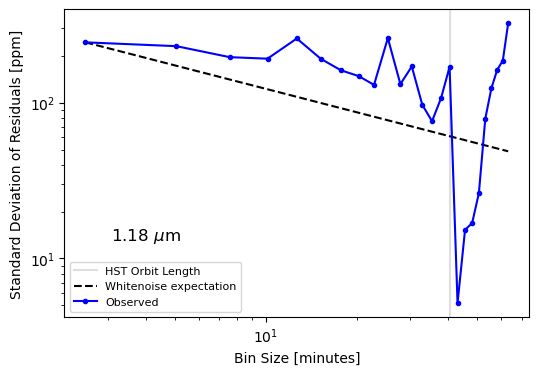

wavelength bin  2  ----
chains loaded in
best fit params computed
batman model initialized
models computed
residuals computed


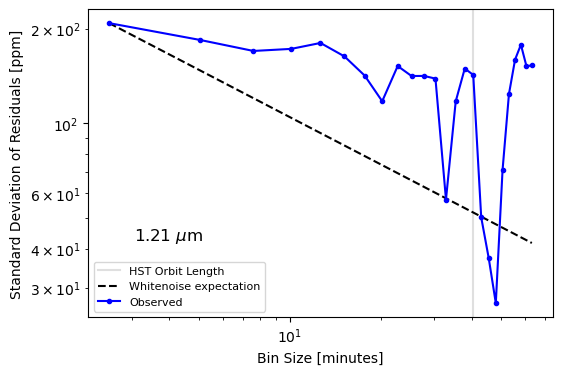

wavelength bin  3  ----
chains loaded in
best fit params computed
batman model initialized
models computed
residuals computed


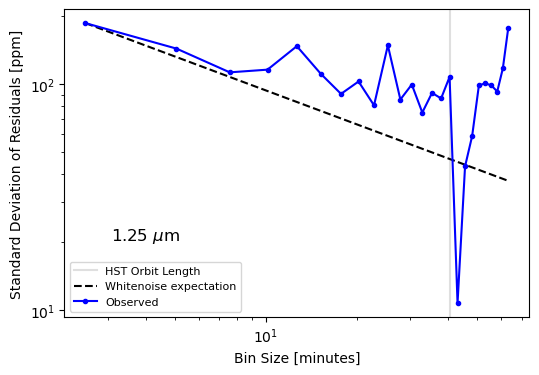

wavelength bin  4  ----
chains loaded in
best fit params computed
batman model initialized
models computed
residuals computed


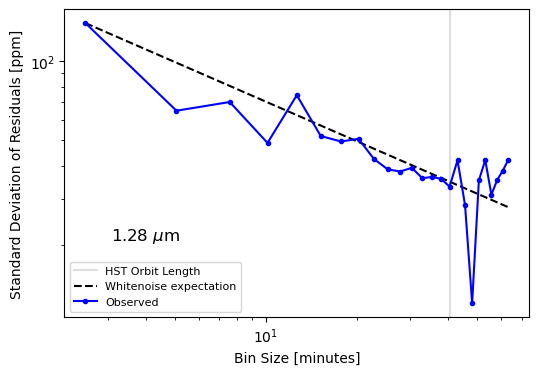

wavelength bin  5  ----
chains loaded in
best fit params computed
batman model initialized
models computed
residuals computed


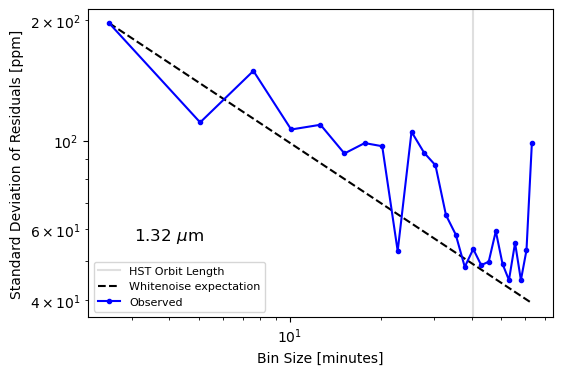

wavelength bin  6  ----
chains loaded in
best fit params computed
batman model initialized
models computed
residuals computed


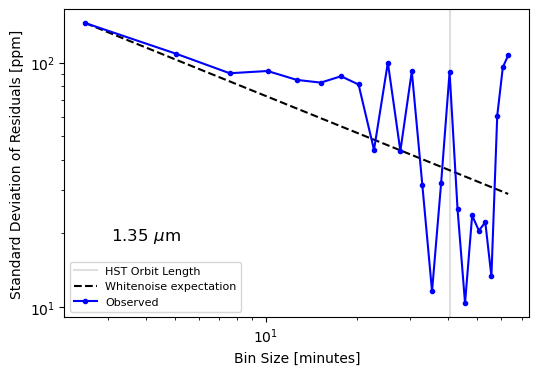

wavelength bin  7  ----
chains loaded in
best fit params computed
batman model initialized
models computed
residuals computed


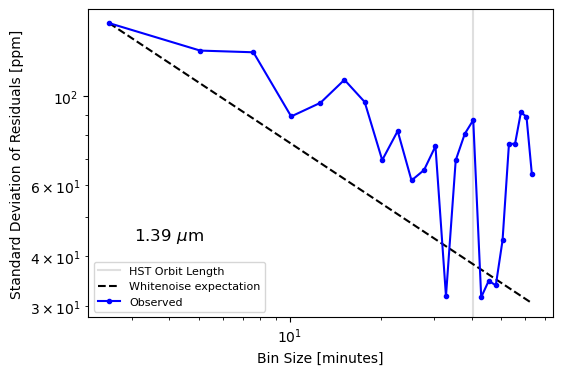

wavelength bin  8  ----
chains loaded in
best fit params computed
batman model initialized
models computed
residuals computed


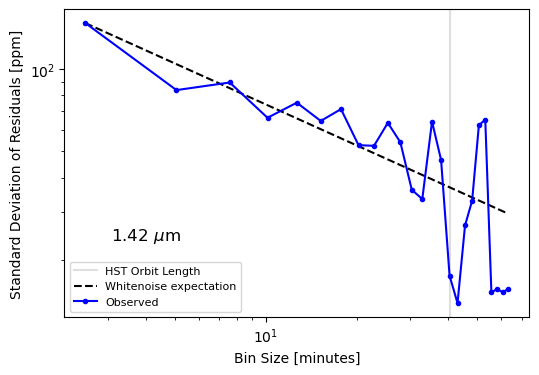

wavelength bin  9  ----
chains loaded in
best fit params computed
batman model initialized
models computed
residuals computed


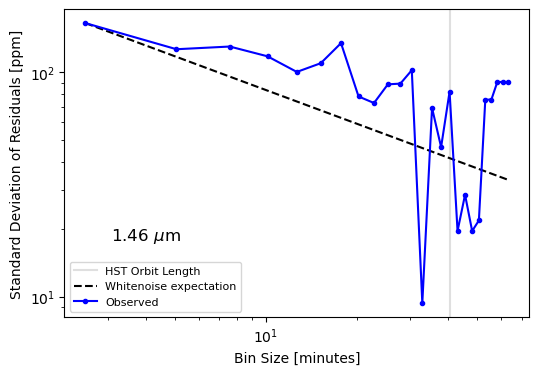

wavelength bin  10  ----
chains loaded in
best fit params computed
batman model initialized
models computed
residuals computed


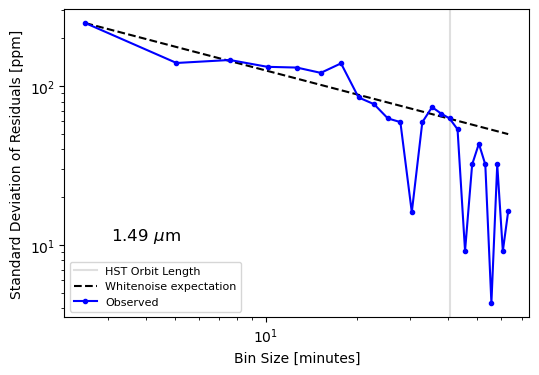

wavelength bin  11  ----
chains loaded in
best fit params computed
batman model initialized
models computed
residuals computed


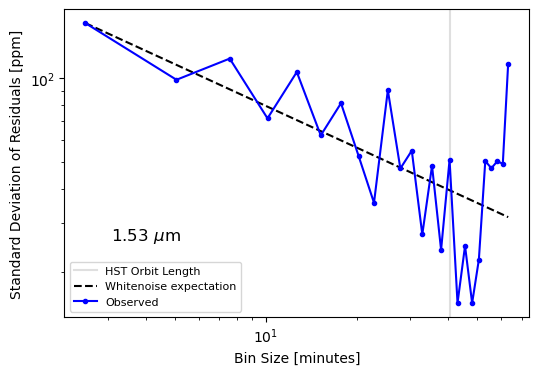

wavelength bin  12  ----
chains loaded in
best fit params computed
batman model initialized
models computed
residuals computed


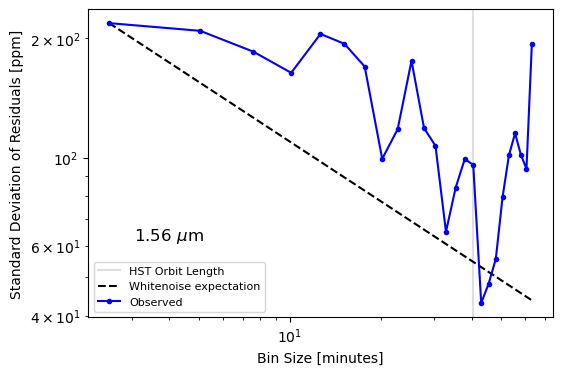

wavelength bin  13  ----
chains loaded in
best fit params computed
batman model initialized
models computed
residuals computed


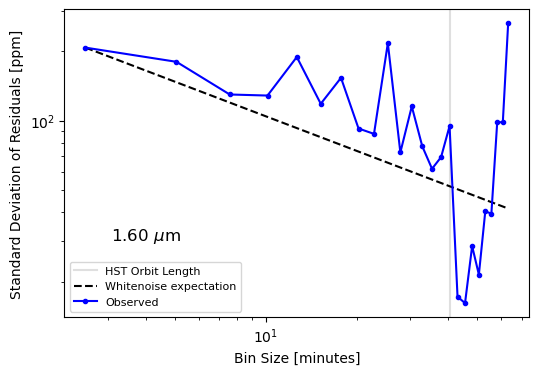

wavelength bin  14  ----
chains loaded in
best fit params computed
batman model initialized
models computed
residuals computed


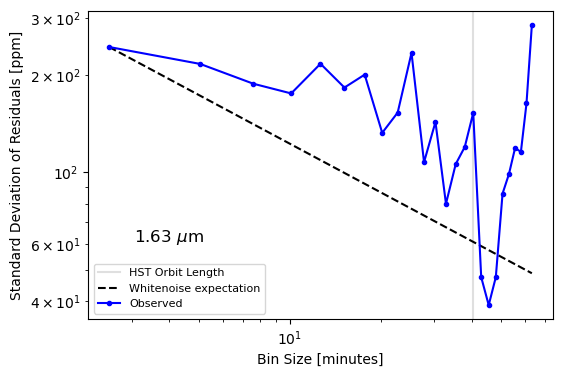

In [85]:
loadSpectral = True
if loadSpectral:
    
    def transit(rprs, initmodel):
        # Transit Light curve model
        # Inputs:
        # theta = array of lightcurve parameters
        # initmodel = pre-initialized BATMAN model environment, which increases efficiency

        # Unpack input parameters
        tc = t0_fixed       # time of conjunction [days]
        P = P_fixed  # compute Period in [day]
        a = a_fixed  # compute a/Rstar
        inc = inc_fixed  # Compute inclination in [deg]
        ecc = ecc_fixed    # use these if assuming circular orbit
        omega = w_fixed
        rprstar = np.copy(rprs)

        # Set batman parameters
        params = batman.TransitParams()
        params.t0 = tc             # transit midpoint [day]
        params.per = P    # log10 (period [day])
        params.rp = rprstar
        params.a = a      # log10 (semi major axis [Rstar])
        params.inc = inc  # cosine inclination [degrees]
        params.ecc = ecc
        params.w = omega
        params.limb_dark = 'quadratic'
        params.u = u_fixed

        lightcurve = initmodel.light_curve(params)
        return lightcurve
    ##
    # Defining my systematic models
    def hook(theta, torbit):
        # Orbit-long charge trapping hook model for HST
        # Inputs:
        # theta = array of lightcurve parameters
        # torbit = time since start of corresponding orbit in units [day]

        amplitude2 = theta[1]
        amplitude3 = theta[2]
        tau2 = theta[3]
        tau3 = theta[4]

        hookcurve = np.zeros(len(t_orbit))
        hookcurve[:17] = 1. - amplitude2*np.exp(torbit[:17]/tau2)
        hookcurve[17:] = 1. - amplitude3*np.exp(torbit[17:]/tau3)
        return hookcurve

    def ramp(theta, tvisit):
        # Visit-long linear model for flux in time
        slope = theta[5]
        intercept = theta[6]

        y = intercept + (slope*tvisit)
        return y
    
    ## Loading in the extracted, binned spectral lighcurves
    tsdata = np.load('/home/mmmurphy/data/hd219666b/reduced_data/Transit_Spectra_NoFirst_Visit3.npz')
    times = tsdata['time']
    rawfluxes = tsdata['flux']
    rawerrors = tsdata['error']
    scandirs = tsdata['scandir']
    wavelengths = tsdata['WaveCenters']  # [microns]
    print('data loaded in')

    t_visit = times - times[0]
    # Pull out times [in day; MJD] of each orbit
    orbit_ends = np.array([17, 34, 51])
    orbit2times = times[:orbit_ends[0]]
    orbit3times = times[orbit_ends[0] : orbit_ends[1]]
    orbit4times = times[orbit_ends[1] : orbit_ends[2]]

    # From above, compute time since beginning of orbit for each
    tinorbit2 = orbit2times - orbit2times[0]
    tinorbit3 = orbit3times - orbit3times[0]
    tinorbit4 = orbit4times - orbit4times[0]
    t_orbit = np.concatenate((tinorbit2, tinorbit3, tinorbit4))

    fluxes = np.copy(rawfluxes)
    errors = np.copy(rawerrors)
    Nbins = rawfluxes.shape[0]
    for wav in range(Nbins):
        sd1_idxs = np.where(scandirs == 1.)[0]
        sd0_idxs = np.where(scandirs == 0.)[0]

        normval1 = np.median(fluxes[wav, sd1_idxs])
        normval0 = np.median(fluxes[wav, sd0_idxs])

        fluxes[wav, sd1_idxs] /= normval1
        errors[wav, sd1_idxs] /= normval1
        fluxes[wav, sd0_idxs] /= normval0
        errors[wav, sd0_idxs] /= normval0
        
    Npoints = fluxes.shape[1]
    Nwaves = fluxes.shape[0]
    
    for wavebin in range(Nwaves):
#         if wavebin != 0:
#             continue
        print('wavelength bin ', wavebin, ' ----')
        path = '/home/mmmurphy/data/hd219666b/mcmc_results/tspec/'
        ffile = path+'flatsamples_wav'+str(wavebin)+'.npy'
        wav_flatsamples = np.load(ffile)
        print('chains loaded in')
    
        param_fits = np.asarray([np.median(wav_flatsamples[:,i]) for i in range(wav_flatsamples.shape[1])])
        param_uperrs = np.asarray([np.percentile(wav_flatsamples[:,i], 84) for i in range(wav_flatsamples.shape[1])]) - param_fits
        param_loerrs = param_fits - np.asarray([np.percentile(wav_flatsamples[:,i], 16) for i in range(wav_flatsamples.shape[1])])
        param_errs = np.mean((param_uperrs, param_loerrs), axis=0)
        print('best fit params computed')
        
        rprs_init, rprs_init_unc = 0.0429416, 0.00033254
        t0_fixed = 2458329.2016137  # [day]
        P_fixed =  10. ** 0.780639       # [day]
        a_fixed = 10. ** 1.12013           # [Rs]
        inc_fixed = (180. / np.pi) * np.arccos(np.fabs(0.0633181))   # [degrees]
        ecc_fixed = 0.
        w_fixed = 90.
        u_fixed = [0.16, 0.31]

        # Initializing the BATMAN model
        InitParams = batman.TransitParams()
        InitParams.t0 = t0_fixed     
        InitParams.per = P_fixed
        InitParams.a = a_fixed
        InitParams.inc = inc_fixed
        InitParams.rp = rprs_init
        InitParams.ecc = ecc_fixed
        InitParams.w = w_fixed
        InitParams.limb_dark = 'quadratic'
        InitParams.u = u_fixed
        BATMAN_initmodel = batman.TransitModel(InitParams, times)
        print('batman model initialized')
        
        wav_transit = transit(param_fits[0], BATMAN_initmodel)
        wav_hook = hook(param_fits, t_orbit)
        wav_ramp = ramp(param_fits, t_visit)
        wav_sys = wav_hook * wav_ramp
        wav_model = wav_transit * wav_sys
        print('models computed')
        
        wav_flux, wav_err = fluxes[wavebin, :], errors[wavebin,:]
        wav_detflux, wav_deterr = wav_flux / wav_sys, wav_err / wav_sys
        wav_residuals = 1.e6*(wav_flux - wav_model)
        print('residuals computed')
        
        max_every_N_to_bin = 25
        mean_resids = np.zeros(max_every_N_to_bin)
        sd_resids = np.zeros(max_every_N_to_bin)
        timesteps = np.zeros(max_every_N_to_bin)
        t_exp = times[1] - times[0]
        for bin_size in range(max_every_N_to_bin):
            #print('binning every %d points'%(bin_size + 1))
            this_binnings_residuals = []
            binn = 0
            while binn < len(residuals_bb):
                #print('bin number %d'%(binn))
                vals_to_combine = []
                for nextn in range(bin_size+1):
                    if (binn + nextn) >= len(wav_residuals):
                        continue
                    vals_to_combine.append(wav_residuals[binn+nextn])
                vals_to_combine = np.asarray(vals_to_combine)
                #print('values: ',vals_to_combine)
                median_value = np.median(vals_to_combine)
                this_binnings_residuals.append(median_value)
                binn += (bin_size + 1)

            this_binnings_residuals = np.asarray(this_binnings_residuals)
            mu, sd = norm.fit(this_binnings_residuals)
            mean_resids[bin_size] = mu
            sd_resids[bin_size] = sd

            timestep_size = t_exp * (bin_size + 1)
            timestep_size_min = timestep_size * 24. * 60.
            timesteps[bin_size] = timestep_size_min

        whitenoise_x = np.copy(timesteps)
        whitenoise_y = np.zeros(len(whitenoise_x))
        for i, val in enumerate(whitenoise_x):
            N = i + 1
            unbinned_sd = sd_resids[0]
            wn_sd = unbinned_sd / np.sqrt(N)
            whitenoise_y[i] = wn_sd

        orbit_length = tinorbit2[-1]
        orbit_length_min = orbit_length * 24. * 60.
        fig, ax = plt.subplots(figsize=(6,4))
        ax.axvline(orbit_length_min, c='gray', alpha=0.25, label='HST Orbit Length')
        ax.plot(whitenoise_x, whitenoise_y, c='black', ls='--', label='Whitenoise expectation')
        ax.plot(timesteps, sd_resids, c='blue', marker='o', ms=3, label='Observed')
        ax.text(0.1, 0.25, r'%.2f $\mu$m'%(wavelengths[wavebin]), c='black', fontsize=12, transform=ax.transAxes)
        ax.set(xlabel='Bin Size [minutes]', ylabel='Standard Deviation of Residuals [ppm]', xscale='log', yscale='log')
        ax.legend(loc='lower left', fontsize=8, frameon=True)
        figname = 'figures/whitenoise_comp_wav'+str(wavebin)+'.png'
        plt.savefig(figname, dpi=400, bbox_inches='tight')
        plt.show()




In [74]:
flatsamples.shape

(2400000, 16)